Comparing Mobile Net V2 performance with and without memory+ layer

In [21]:
import sys
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.profiler import profile, record_function, ProfilerActivity
import timm
import math
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
class MemoryPlusLayer(nn.Module):

    def __init__(self, d_model, memory_slots, top_k = 32):
        # Define your memory mechanism here
        # Using Berges et al. (2024) "Memory Layers at scale" as a reference for the memory layer design

        super().__init__()

        self.key_dim = d_model // 2
        self.subkey_dim = self.key_dim // 2
        self.value_dim = d_model # <-- NOTE: May experiment with this value, as it may affect performance and memory usage.

        # Total memory_slots = |C| * |C'|. Sub-key matrices have sqrt(memory_slots) rows.
        self.num_subkeys = math.isqrt(memory_slots)
        assert self.num_subkeys ** 2 == memory_slots, f"memory_slots (n = {memory_slots}) must be a perfect square."

        # Query MLP
        self.query = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.SiLU(), # <-- Should ideally match whatever the base models FFN activation function is.
            nn.Linear(d_model * 4, self.subkey_dim)
        )

        # Sub-Key Matrix One and Two
        # NOTE: Don't use nn.linear here, due to sparse key retrieval mechanism in forward pass.
        self.subkey_one = nn.Parameter(torch.empty(self.num_subkeys, self.subkey_dim, dtype=torch.float32))
        self.subkey_two = nn.Parameter(torch.empty(self.num_subkeys, self.subkey_dim, dtype=torch.float32))
        nn.init.uniform_(self.subkey_one, a = -1, b = 1)
        nn.init.uniform_(self.subkey_two, a = -1, b = 1)

        # Value Matrix
        self.values = nn.Parameter(torch.empty(memory_slots, self.value_dim, dtype=torch.float32))
        nn.init.normal_(self.values, std=0.02)  # apparently from lample et al 2019, CAN't FIND ITS REFERENCE

        # Weight Matrix One
        self.W1 = nn.Linear(d_model, self.value_dim, bias=False)

        # Weight Matrix Two
        self.W2 = nn.Linear(self.value_dim, d_model, bias=False)

        # Silu Activation Function
        self.silu = nn.SiLU()

        # QK-Normalisation,
        # NOTE:I think its more a general backbone design choice for memory layer, potentially place this after residual connection as we are using interleaved architecture (at end of this gated memory layer)
        """
        NOTE: This is a technique used to stabilize training and improve convergence in transformer models.
        """
        self.qk_norm = nn.RMSNorm(self.subkey_dim)

        # Top-K Selection
        """
        NOTE: Can experiment with this value, as it may affect performance and memory usage.
        """
        self.top_k = top_k

        # Softmax
        self.softmax = nn.Softmax(dim=-1)


    def lookup_memory(self, query):

        # 1. Apply normalisation for cosine similarity style lookup
        k1 = self.qk_norm(self.subkey_one)
        k2 = self.qk_norm(self.subkey_two)

        # 2. Get similarity subkey scores with query
        sim_scores_1 = query @ k1.T
        sim_scores_2  = query @ k2.T
        all_scores = sim_scores_1.unsqueeze(-1) + sim_scores_2.unsqueeze(-2)

        # 3. Cartesian Product Search:
        all_scores = all_scores.view(*all_scores.shape[:-2], -1)

        # 4. Select the final top-k combinations
        top_k_scores, top_k_indices = torch.topk(all_scores, self.top_k, dim=-1)

        # 5. Retrieve Values and Aggregate
        s = self.softmax(top_k_scores)

        # 6. Gather Values and Aggregate: NOTE: Using EmbeddingBag!
        # TODO: Make CUDA kernel to quicken EmbeddingBag solution
        flat_indices = top_k_indices.view(-1, self.top_k)
        flat_weights = s.view(-1, self.top_k)
        y_flat = F.embedding_bag(flat_indices, self.values, per_sample_weights=flat_weights, mode='sum')

        return y_flat.view(*query.shape[:-1], self.value_dim)

    def forward(self, x):

        q = self.query(x)
        q = self.qk_norm(q)

        y = self.lookup_memory(q)

        m_plus = self.silu(self.W1(x))
        m_plus = y * m_plus
        m_plus = self.W2(m_plus)

        return m_plus

In [22]:
def profile_model_performance(model, device, name="Model"):
    """Profiles a single forward and backward pass to see memory/FLOP tradeoffs."""
    print(f"\n--- Profiling {name} ---")
    model.eval()
    inputs = torch.randn(1, 3, 224, 224).to(device)



    with profile(
        activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA] if torch.cuda.is_available() else [ProfilerActivity.CPU],
        record_shapes=True,
        profile_memory=True,
        with_stack=True
    ) as prof:
        with record_function("forward_pass"):
            output = model(inputs)
        with record_function("backward_pass"):
            loss = output.sum()
            loss.backward()

    # Sorted by CUDA time if available, else CPU time
    sort_by = "cuda_time_total" if torch.cuda.is_available() else "cpu_time_total"
    print(prof.key_averages().table(sort_by=sort_by, row_limit=10))

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    # set tqdm on loader for a visual progress bar
    pbar = tqdm(loader, desc="Training", unit="batch", leave=False)

    for images, labels in loader:

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{100. * correct / total:.2f}%"
        })
    return running_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return running_loss / len(loader), 100. * correct / total

def run_comparison(dense_model, memory_model, train_loader, test_loader, device, epochs=5):
    # Detect device (Note: MPS for Mac is an option, but profiler support varies)

    # Fixed keys to match your storage logic
    results = {'dense': {'val_loss': [], 'val_acc': []}, 'memory': {'val_loss': [], 'val_acc': []}}
    speed_comp = {dense_model : 0.0, memory_model : 0.0}
    for name, model in [('dense', dense_model), ('memory', memory_model)]:
        print(f"\nStarting training for {name}...")
        optimizer = optim.AdamW(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()
        start_time = time.time()
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            print(f"Epoch {epoch+1}: train loss: {train_loss}, train acc: {train_acc}")
            val_loss, val_acc = validate(model, test_loader, criterion, device)

            results[name]['val_loss'].append(val_loss)
            results[name]['val_acc'].append(val_acc)
            print(f"Epoch {epoch+1}: Val Acc {val_acc:.2f}%")

        end_time = time.time()
        speed_comp[model] = end_time - start_time



    return results, speed_comp

In [39]:
# Plotting Accuracy
def plot_results(results):
    plt.figure(figsize=(8, 5))
    plt.plot(results['dense']['val_acc'], label='Dense Baseline ViT')
    plt.plot(results['memory']['val_acc'], label='Memory+ ViT')
    plt.title('FashionMNIST Validation Accuracy Comparison')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()


In [5]:
# Init Device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device

device(type='cuda')

In [32]:
# Init Dataset

transform = transforms.Compose([
    transforms.Resize(224),                    # ViT models typically expect 224x224
    transforms.Grayscale(num_output_channels=3), # Convert 1-channel to 3-channel for ViT
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))        # Single channel mean/std (replicated to 3)
])

train_set = datasets.FashionMNIST(root='./data_dir', train=True, download=True, transform=transform)
test_set = datasets.FashionMNIST(root='./data_dir', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)


In [ ]:
# Init Models

# MAY OF INITIALISED NUM CLASSES WRONG DUE TO FASHION-MNIST DATA
dense_model = timm.create_model('vit_tiny_patch16_224', pretrained=False, num_classes=100, cache_dir="./models_dir").to(device)
memory_model = timm.create_model('vit_tiny_patch16_224', pretrained=False, num_classes=100, cache_dir = "./models_dir").to(device)


d_model = dense_model.embed_dim
memory_slots = 256**2
memory_model.blocks[6].mlp = MemoryPlusLayer(d_model=d_model, memory_slots=memory_slots).to(device)

In [34]:
"""VERY IMPORTANT NOTE:

Base model is 17x faster than Memory+ (1024**2 memory slots) ViT!!!!
NEED CUSTOM KERNEL FOR EMBEDDINGBAG SOLUTION TO SPEED THIS UP,
AS THIS IS THE BOTTLENECK IN THE MEMORY LAYER.

Hoever found memory slot size 256**2 to be near speed of baseline!

"""

# PROFILE MODELS BEFORE TRAINING TO SEE MEMORY/FLOP TRADEOFFS
profile_model_performance(dense_model, device, name="Dense Baseline")
profile_model_performance(memory_model, device, name="Memory+ Adapter")


--- Profiling Dense Baseline ---
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
    autograd::engine::evaluate_function: AddmmBackward0         1.59%       1.610ms        12.46%      12.648ms     258.125us       0.000us         0.00%       4.893ms      99.847us           0 B       

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
    autograd::engine::evaluate_function: AddmmBackward0         1.50%     917.932us        11.87%       7.277ms     148.500us       0.000us         0.00%       4.885ms      99.694us           0 B           0 B       9.42 MB     -22.70 M

In [35]:
res, speeds = run_comparison(dense_model, memory_model, train_loader, test_loader, device, epochs=5)



Starting training for dense...
Epoch 1/5



Training:   0%|          | 0/469 [05:12<?, ?batch/s, loss=0.8019, acc=56.39%]
                                                                             

Epoch 1: train loss: 1.3994335513125096, train acc: 56.39333333333333
Epoch 1: Val Acc 70.74%
Epoch 2/5



Training:   0%|          | 0/469 [05:24<?, ?batch/s, loss=0.5112, acc=74.94%]
                                                                             

Epoch 2: train loss: 0.6857880375532708, train acc: 74.94333333333333
Epoch 2: Val Acc 77.12%
Epoch 3/5



Training:   0%|          | 0/469 [05:28<?, ?batch/s, loss=0.5452, acc=80.51%]
                                                                             

Epoch 3: train loss: 0.5388836352937003, train acc: 80.51166666666667
Epoch 3: Val Acc 81.60%
Epoch 4/5



Training:   0%|          | 0/469 [05:28<?, ?batch/s, loss=0.2785, acc=83.72%]
                                                                             

Epoch 4: train loss: 0.4556894478386145, train acc: 83.71666666666667
Epoch 4: Val Acc 83.27%
Epoch 5/5



Training:   0%|          | 0/469 [05:28<?, ?batch/s, loss=0.3354, acc=85.27%]
                                                                             

Epoch 5: train loss: 0.40830256086168515, train acc: 85.27333333333333
Epoch 5: Val Acc 84.89%

Starting training for memory...
Epoch 1/5



Training:   0%|          | 0/469 [08:08<?, ?batch/s, loss=0.9076, acc=57.34%]
                                                                             

Epoch 1: train loss: 1.4033657046777608, train acc: 57.34166666666667
Epoch 1: Val Acc 71.69%
Epoch 2/5



Training:   0%|          | 0/469 [08:07<?, ?batch/s, loss=0.6568, acc=76.08%]
                                                                             

Epoch 2: train loss: 0.6664158877914649, train acc: 76.08
Epoch 2: Val Acc 78.41%
Epoch 3/5



Training:   0%|          | 0/469 [08:06<?, ?batch/s, loss=0.5214, acc=81.18%]
                                                                             

Epoch 3: train loss: 0.5264467691053459, train acc: 81.18333333333334
Epoch 3: Val Acc 82.34%
Epoch 4/5



Training:   0%|          | 0/469 [08:04<?, ?batch/s, loss=0.4394, acc=83.95%]
                                                                             

Epoch 4: train loss: 0.44580988519227327, train acc: 83.94833333333334
Epoch 4: Val Acc 84.52%
Epoch 5/5



Training:   0%|          | 0/469 [08:09<?, ?batch/s, loss=0.3074, acc=85.90%]
                                                                             

Epoch 5: train loss: 0.3927299883891779, train acc: 85.90333333333334
Epoch 5: Val Acc 85.57%


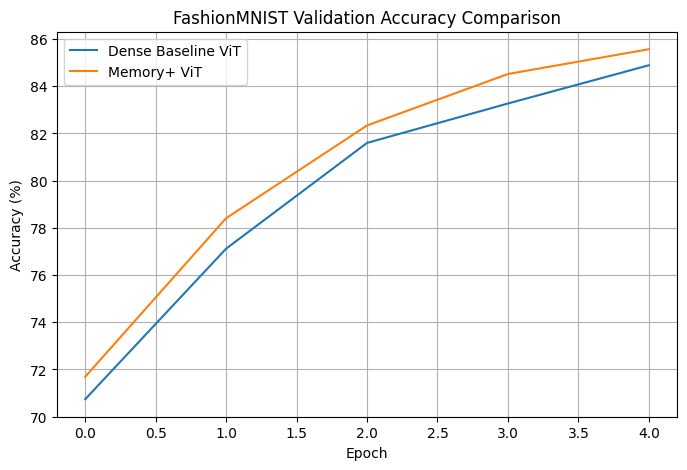

In [40]:
plot_results(res)

In [43]:
for m in speeds.keys():
    print(f"Training Time: {speeds[m]:.2f} seconds")

Training Time: 1764.91 seconds
Training Time: 2677.61 seconds
